In [1]:
import os

# Get the total number of CPUs
total_num_cpus = os.cpu_count()
fraction_to_use = 0.2
num_cpus_to_use = 1 #int(total_num_cpus * fraction_to_use)

# Set the environment variables
os.environ["OMP_NUM_THREADS"] = str(num_cpus_to_use)
os.environ["OPENBLAS_NUM_THREADS"] = str(num_cpus_to_use)
os.environ["MKL_NUM_THREADS"] = str(num_cpus_to_use)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(num_cpus_to_use)
os.environ["NUMEXPR_NUM_THREADS"] = str(num_cpus_to_use)

In [2]:
import numpy as np
import tensorflow as tf
import keras as K

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.optimize import curve_fit


[1/198] sigma=1.0 kT, alpha=0.10 nm, rate=MA | Elapsed: 0.0s, Remaining: 0.4s
[2/198] sigma=1.0 kT, alpha=0.10 nm, rate=Marcus | Elapsed: 462.8s, Remaining: 45351.3s
[3/198] sigma=1.0 kT, alpha=0.15 nm, rate=MA | Elapsed: 911.5s, Remaining: 59247.0s
[4/198] sigma=1.0 kT, alpha=0.15 nm, rate=Marcus | Elapsed: 1360.4s, Remaining: 65979.0s
[5/198] sigma=1.0 kT, alpha=0.20 nm, rate=MA | Elapsed: 1806.3s, Remaining: 69724.9s
[6/198] sigma=1.0 kT, alpha=0.20 nm, rate=Marcus | Elapsed: 2266.9s, Remaining: 72541.6s
[7/198] sigma=1.0 kT, alpha=0.25 nm, rate=MA | Elapsed: 2711.7s, Remaining: 73992.0s
[8/198] sigma=1.0 kT, alpha=0.25 nm, rate=Marcus | Elapsed: 3179.3s, Remaining: 75507.4s
[9/198] sigma=1.0 kT, alpha=0.30 nm, rate=MA | Elapsed: 3619.6s, Remaining: 76012.1s
[10/198] sigma=1.0 kT, alpha=0.30 nm, rate=Marcus | Elapsed: 4074.3s, Remaining: 76596.1s
[11/198] sigma=1.0 kT, alpha=0.35 nm, rate=MA | Elapsed: 4525.4s, Remaining: 76932.4s
[12/198] sigma=1.0 kT, alpha=0.35 nm, rate=Marcus | 

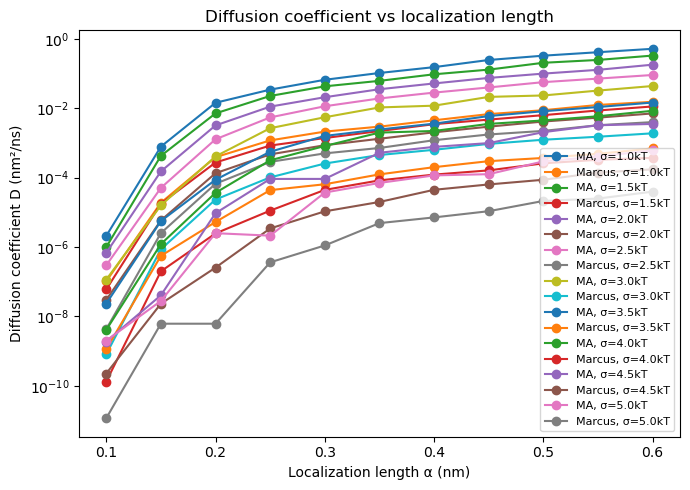

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ------------------- Parameters (ns units) -------------------
kT = 0.025  # eV
density = 1.0  # sites/nm^3
L = 40.0  # nm
nu0 = 1e3  # ns^-1
lambda_eV = 16*kT
rcut = 5.0
max_hops = 40000
n_traj = 100

# Sigma and alpha grids
sigma_kT_factors = np.arange(1, 5.01, 0.5)
alpha_list = np.arange(0.1, 0.61, 0.05)

# ------------------- Helpers -------------------
def minimum_image(vec, L):
    return vec - L*np.round(vec/L)

def build_sites(N_sites,L):
    return np.random.rand(N_sites,3)*L

def build_neighbor_list(positions, rcut, L):
    try:
        from scipy.spatial import cKDTree as KDTree
        tree = KDTree(positions, boxsize=L)
        neighbors = tree.query_ball_tree(tree, rcut)
        distances = []
        for i,nbrs in enumerate(neighbors):
            nbrs = [j for j in nbrs if j!=i]
            vecs = positions[nbrs]-positions[i]
            vecs = minimum_image(vecs,L)
            rdist = np.sqrt((vecs**2).sum(axis=1))
            distances.append((nbrs, rdist))
        return distances
    except:
        N = len(positions)
        nbrs_all=[]
        for i in range(N):
            dvec = positions - positions[i]
            dvec = minimum_image(dvec,L)
            dists = np.sqrt((dvec**2).sum(axis=1))
            nbrs = np.where((dists<=rcut) & (dists>1e-12))[0].tolist()
            nbrs_all.append((nbrs,dists[nbrs]))
        return nbrs_all

# ------------------- Rates -------------------
def rates_vector(Ei, Ej, rdist, alpha, rate_type):
    deltaE = Ej - Ei
    if rate_type=="MA":
        energy_factor = np.where(deltaE>0, np.exp(-deltaE/kT), 1.0)
    else:
        energy_factor = np.exp(-((deltaE+lambda_eV)**2)/(4*lambda_eV*kT))
    return nu0 * np.exp(-2*rdist/alpha) * energy_factor

# ------------------- Trajectory -------------------
def run_trajectory_vec(positions, energies, neighbors_dist, alpha, rate_type, max_hops):
    N = len(positions)
    cur = np.random.randint(N)
    pos0 = positions[cur].copy()
    t_total = 0.0
    for step in range(max_hops):
        nbrs, rdist = neighbors_dist[cur]
        if len(nbrs)==0: break
        Ej = energies[nbrs]
        rates = rates_vector(energies[cur], Ej, rdist, alpha, rate_type)
        Rtot = rates.sum()
        if Rtot<=0: break
        dt = -np.log(np.random.rand())/Rtot
        t_total += dt
        probs = rates/Rtot
        idx = np.searchsorted(np.cumsum(probs), np.random.rand(), side='right')
        if idx>=len(nbrs): idx=len(nbrs)-1
        cur = nbrs[idx]
    d = positions[cur]-pos0
    d = minimum_image(d,L)
    rsq = (d**2).sum()
    return rsq, t_total

# ------------------- Study -------------------
def run_study():
    N_sites = int(density*L**3)
    positions = build_sites(N_sites,L)
    neighbors_dist = build_neighbor_list(positions, rcut,L)
    
    D_data = np.zeros((len(sigma_kT_factors), len(alpha_list), 2))  # 0=MA,1=Marcus
    total_runs = len(sigma_kT_factors)*len(alpha_list)*2
    run_count = 0
    start_time = time.time()
    
    for i_sigma, sigma_factor in enumerate(sigma_kT_factors):
        sigma = sigma_factor*kT
        energies = np.random.normal(0,sigma,N_sites)
        for i_alpha, alpha in enumerate(alpha_list):
            for j_rate, rate_type in enumerate(["MA","Marcus"]):
                run_count += 1
                elapsed = time.time() - start_time
                remaining = elapsed / run_count * (total_runs - run_count)
                print(f"[{run_count}/{total_runs}] sigma={sigma_factor} kT, alpha={alpha:.2f} nm, rate={rate_type} | "
                      f"Elapsed: {elapsed:.1f}s, Remaining: {remaining:.1f}s")
                
                rsq_list = []
                t_list = []
                for _ in range(n_traj):
                    rsq, t_total = run_trajectory_vec(positions, energies, neighbors_dist, alpha, rate_type, max_hops)
                    rsq_list.append(rsq)
                    t_list.append(t_total)
                
                avg_rsq = np.mean(rsq_list)
                avg_t_ns = np.mean(t_list)
                D_data[i_sigma, i_alpha, j_rate] = avg_rsq/(6*avg_t_ns)
                
    return D_data

# ------------------- Run study -------------------
D_data = run_study()

# ------------------- Save as numpy file -------------------
np.savez("kmc_diffusion_data.npz", D=D_data, alpha=alpha_list, sigma=sigma_kT_factors)

# ------------------- Plot -------------------
plt.figure(figsize=(7,5))
for i_sigma, sigma_factor in enumerate(sigma_kT_factors):
    for j_rate, rate_type in enumerate(["MA","Marcus"]):
        plt.plot(alpha_list, D_data[i_sigma,:,j_rate], marker='o', label=f"{rate_type}, σ={sigma_factor}kT")
plt.xlabel("Localization length α (nm)")
plt.ylabel("Diffusion coefficient D (nm²/ns)")
plt.yscale('log')
plt.title("Diffusion coefficient vs localization length")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()
